In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sys.path.insert(0, '../kinetic_analysis')
from kinetic_function import (single_track_analysis,
                              generate_track
                             )

In [2]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [3]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/04-ProtLength/"

In [5]:
first_time = True
for prot in ["snail", "very_long_prot"]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size[prot]
    for i in range(100):
        x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size[prot], 
                                                      suntag_length = prot_aa_size["32xsuntag"], 
                                                      nb_suntag=32, 
                                                      fluo_one_suntag=4,
                                                      translation_rate=24, 
                                                      binding_rate=0.05,
                                                      retention_time=0,
                                                      suntag_pos="begin",
                                                      step = 0.1,
                                                      length=6000)
        if first_time:
            datas = pd.DataFrame({"FRAME":x_global,
                                  "MEAN_INTENSITY_CH1":y_global,
                                  "TRACK_ID" : i,
                                  "PROT":prot,
                                 })
            first_time = False
        else:
            datas = pd.concat([datas, 
                               pd.DataFrame({"FRAME":x_global,
                                              "MEAN_INTENSITY_CH1":y_global,
                                              "TRACK_ID" : i,
                                             "PROT":prot,
                                 })], ignore_index=True)


datas.to_csv(os.path.join(path, "datas_prot_length.csv"))

In [6]:
datas = pd.read_csv(os.path.join(path, "datas_prot_length.csv"))

In [7]:
datas.head()

,Unnamed: 0,FRAME,MEAN_INTENSITY_CH1,TRACK_ID,PROT
0,0,0.0,319.163819,0,snail
1,1,0.1,320.707538,0,snail
2,2,0.2,322.251256,0,snail
3,3,0.3,323.794975,0,snail
4,4,0.4,325.338693,0,snail


In [8]:
first_time = True
for prot in ["snail", "very_long_prot"]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size[prot]
    for i in range(100):
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas[datas["PROT"]==prot], 
                                     i, 
                                     delta_t = 0.1,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalise_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":0.1,
                                   "id":i,
                                   "prot":prot},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":0.1, 
                                          "id":i,
                                         "prot":prot}, index=[0])
                            ], ignore_index=True)
            
results.to_csv(os.path.join(path, "results_prot_length.csv"))       

In [11]:
results.groupby(by='prot')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
prot,,
snail,21.628315,26.541572
very_long_prot,20.363254,26.704813


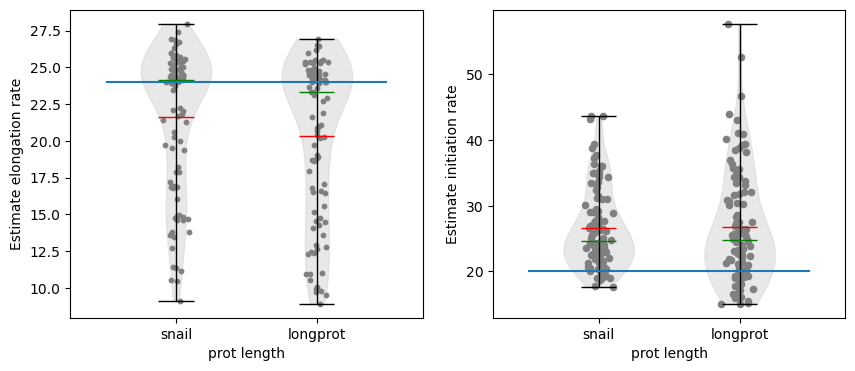

In [12]:
fig, ax = plt.subplots(1,2)


violin = ax[0].violinplot(dataset = [results[results.prot == "snail"]["elongation_r"].values,
                                     results[results.prot == "very_long_prot"]["elongation_r"].values,
                          ],
                         showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1


violin = ax[1].violinplot(dataset = [results[results.prot == "snail"]["init_translation_r"].values,
                                     results[results.prot == "very_long_prot"]["init_translation_r"].values,],
                         showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
group = 'prot'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'prot'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)

def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('prot length')
# set style for the axes
labels = ["snail", "longprot"]
for a in ax:
    set_axis_style(a, labels)

ax[0].set_ylabel("Estimate elongation rate")
ax[1].set_ylabel("Estimate initiation rate")

# ax[1].set_ylim(0,250)
ax[0].hlines(24, 0.5, 2.5)
ax[1].hlines(1/0.05, 0.5, 2.5)
fig.set_size_inches((10,4))
# fig.savefig(os.path.join(path_save, "results_prot_size_boxplot_original.eps"), dpi=300)

(0.0, 100.0)

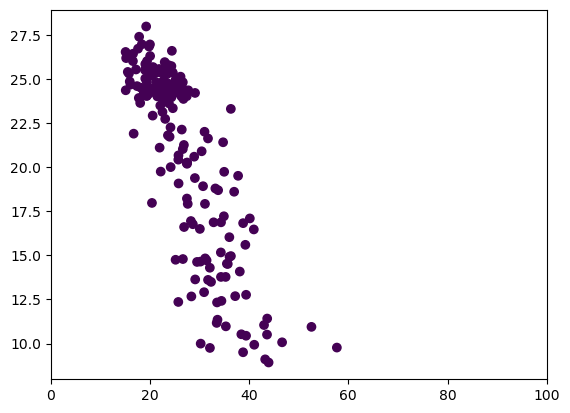

In [13]:
fig, ax = plt.subplots()
ax.scatter(results["init_translation_r"], results["elongation_r"], c=results["prot"].astype(bool))
ax.set_xlim(0,100)

In [15]:
from scipy.stats import bootstrap

d = (results[results.prot == "snail"]["elongation_r"].to_numpy(),)
bootstrap_ci = bootstrap(d,
                          np.mean, 
                          confidence_level=0.95,
                          method="percentile"
                         )
bootstrap_ci.confidence_interval

ConfidenceInterval(low=20.66529921427889, high=22.555635765989752)

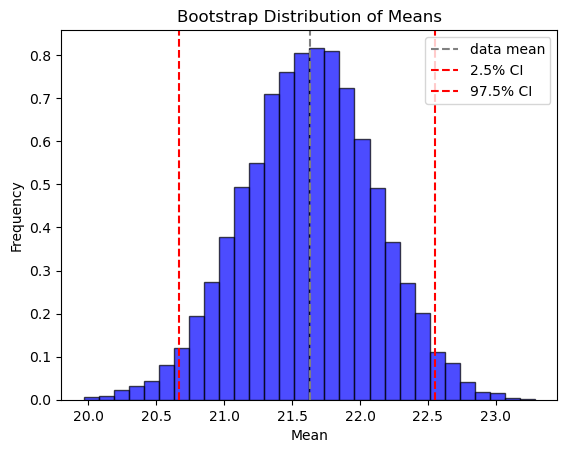

ConfidenceInterval(low=20.66529921427889, high=22.555635765989752)
Bootstrap Mean Estimate: 	21.625458004783546
Bootstrap Median Estimate: 	21.6341663329934
Bootstrap Standard Error: 	0.48181072824503474
Mean: 	21.628315067209872
Bootstrap Bias: -0.002857062426325996


In [16]:
import matplotlib.pyplot as plt

plt.hist(bootstrap_ci.bootstrap_distribution, density=True, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bootstrap Distribution of Means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.axvline(np.mean(d)  , color='grey', linestyle='dashed', label='data mean')
plt.axvline(bootstrap_ci.confidence_interval.low, color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(bootstrap_ci.confidence_interval.high, color='red', linestyle='dashed', label='97.5% CI')
plt.legend()
plt.show()

print(bootstrap_ci.confidence_interval)
# calculate central tendency
mean_estimate = np.mean(bootstrap_ci.bootstrap_distribution)
median_estimate = np.median(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Mean Estimate: \t{mean_estimate}")
print(f"Bootstrap Median Estimate: \t{median_estimate}")

# measure variability
standard_error = np.std(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Standard Error: \t{standard_error}")

# Assess bias
original_statistic = np.mean(d)  
print(f"Mean: \t{original_statistic}")
bias = np.mean(bootstrap_ci.bootstrap_distribution) - original_statistic
print(f"Bootstrap Bias: {bias}")



In [17]:
result_group = results.groupby(by='prot')[['elongation_r','init_translation_r']].mean()
result_group

,elongation_r,init_translation_r
prot,,
snail,21.628315,26.541572
very_long_prot,20.363254,26.704813


In [18]:
result_group["ratio"] = 100*result_group["elongation_r"]/24
result_group

,elongation_r,init_translation_r,ratio
prot,,,
snail,21.628315,26.541572,90.117979
very_long_prot,20.363254,26.704813,84.846893


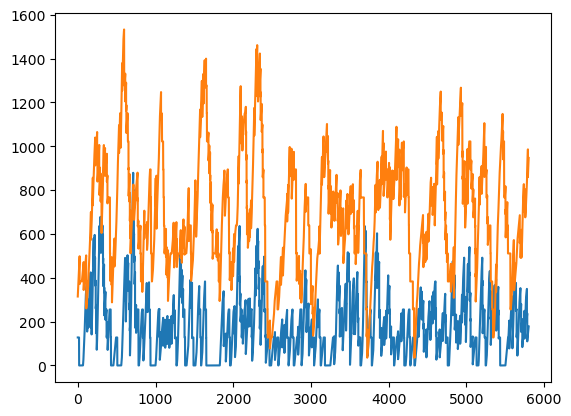

In [19]:
fig, ax = plt.subplots()
for prot in ["snail", "very_long_prot"]:
    for i in range(1):
        ax.plot(datas[(datas["PROT"]==prot) & (datas["TRACK_ID"]==i)]["FRAME"],
               datas[(datas["PROT"]==prot) & (datas["TRACK_ID"]==i)]["MEAN_INTENSITY_CH1"])
        

In [20]:
groupby_datas = pd.DataFrame(datas.groupby(["TRACK_ID", "PROT"]).mean()["MEAN_INTENSITY_CH1"])
groupby_datas["prot"] = groupby_datas.index.get_level_values("PROT")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


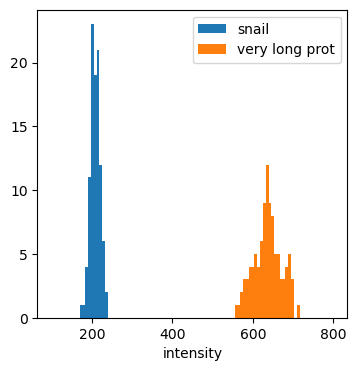

In [21]:
fig, ax = plt.subplots()
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("PROT").isin(["snail"])]["MEAN_INTENSITY_CH1"].to_numpy(), 
          bins=100, 
          range=[100,800],
         label="snail")
_=ax.hist(groupby_datas[groupby_datas.index.get_level_values("PROT").isin(["very_long_prot"])]["MEAN_INTENSITY_CH1"].to_numpy(),
          bins=100, 
          range=[100,800],
         label="very long prot")
ax.legend()
ax.set_xlabel("intensity")

fig.set_size_inches((4,4))
fig.savefig(os.path.join(path_save, "results_prot_size_hist.eps"), dpi=300)